### In this notebook we'll acquaint with dataset library. For this purpose we'll write simple regression models. 

You can see the implementation of MyBatch class in [mybatch.py](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/task_01/mybatch.py),
data generation function in [data_generator.py](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/task_01/data_generator.py), and models in [models.py](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/task_01/models.py).

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from mybatch import MyBatch
from models import Regressions
from data_generator import generate_linear_data, \
                           generate_logistic_data, \
                           generate_poisson_data
from dataset import Dataset, DatasetIndex, V, F, B

## First we consider linear regression, that allows solving tasks where answers are continuous variables.
For this we generate data from uniform or normal distributions, multiply it normally distributed weights and add normally distributed noize and then we try to predict it.

In [2]:
size = 1000
linear_x, linear_y = generate_linear_data(size=size)

Now we create dataset with our class named __MyBatch__ and split it into train/test. We need dataset to create batches in future, but now the dataset is empty until we load the data into it. First of all we create __Index__ for our dataset. __Index__ holds the sequence of data items' indices. This mechanism is needed to uniquely address each data item. You can read more about [using](https://analysiscenter.github.io/dataset/intro/intro.html) Dataset, Dataset [itself](https://analysiscenter.github.io/dataset/intro/dataset.html), and [Index](https://analysiscenter.github.io/dataset/intro/index.html).

In [3]:
ind = DatasetIndex(np.arange(size))
linear_dset = Dataset(ind,batch_class=MyBatch)
linear_dset.cv_split()

As you may see, there are no input and output tensors in our model. They are created inside it, you can control it using 'inputs' key in __config__.

To configure 'inputs' use another dict, which is named __inputs_config__ in the cell below. It's keys are:
* __input__ - name of the placeholder for the input data.
* __labels__ - name of the placeholder for the answers before all transformations.

Values for these keys are dicts themselfs with the following parameters:
* __shape__ - shape of the created placeholder, or in other words, shape of the input(output) to the model.
* __name__ - name of the placeholder after transformations.

For more information see [this](https://analysiscenter.github.io/dataset/api/dataset.models.tf.base.html#dataset.models.tf.TFModel._make_inputs).

In [4]:
inputs_config = {'input': {'shape': (13)},
                 'labels': {'shape': (1),
                            'name': 'targets'}}

 Before we talk about training our model, we will need to know how the parameters are formed for it. This occurs in the __config__ of the model. It looks like that: 

In [5]:
config={'inputs': inputs_config,
        'loss': 'mse',
        'optimizer': {'name':'GradientDescentOptimizer',
                      'learning_rate': 0.01},
        'input_block/inputs': 'input',
        'body/units': 1}

config keys:
* __inputs__ - was consider above
* __optimizer__ - dist with optimizer and parameters for it
* __loss__ - loss for our model, can be dict with parameters too
* __input_block/inputs__ - name of tensor which is an input of input block
* __body/units__ - number of filters on fully-connected layer. In our case there is one output filter.

Нou can read [here](https://analysiscenter.github.io/dataset/intro/tf_models#configuration) and [here](https://analysiscenter.github.io/dataset/intro/models#configuring-a-model) about _config_ and how configurate model. 

After creating a dataset we need to load data and train linear regression model, that implemented into [model](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/task_01/models.py) class.
We can train it on batch of generated data, which we preload before. For this we create __pipeline__, that allows using trained model in one line of code! You can read more [here](https://analysiscenter.github.io/dataset/intro/pipeline.html).

In __pipeline__ we create a linear regression model and train it use train_model function. You can read how it works [here](https://analysiscenter.github.io/dataset/intro/tf_models). About train_model you can read [this](https://analysiscenter.github.io/dataset/intro/models.html#training-a-model).

In [6]:
BATCH_SIZE = 100
train_linear = (linear_dset.train.p
                .load((linear_x, linear_y))
                .init_variable('loss_values', init_on_each_run=list)
                .init_model('dynamic',
                            Regressions,
                            'linear',
                            config=config)
                .train_model('linear',
                             fetches='loss',
                             feed_dict={'input': B('input_data'),
                                        'labels': B('labels')},
                            save_to=V('loss_values'), mode='a')
                .run(BATCH_SIZE, shuffle=True, n_epochs=100))

And pipeline to predict test data. About predict_model read [this](https://analysiscenter.github.io/dataset/intro/models.html#predicting-with-a-model).

In [7]:
BATCH_SIZE = 1
test_linear = (linear_dset.test.p
                .import_model('linear', train_linear)
                .load((linear_x, linear_y))
                .init_variable('predict', init_on_each_run=list)
                .predict_model('linear', 
                             fetches='Regressions/predictions',
                             feed_dict={'input': B('input_data'),
                                        'labels': B('labels')},
                             save_to=V('predict'), mode='a')
                .run(BATCH_SIZE, shuffle=False, n_epochs=1))

In last __pipeline__ we test our model. Let's see, how good to do it.

In [8]:
predict = np.array(test_linear.get_variable('predict')).reshape(-1)
target = np.array(linear_y[linear_dset.test.indices]).reshape(-1)

percent = np.mean(np.abs((target - predict) * 100 / target))

print('Percentage of errors: {}%'.format(round(percent, 3)))

Percentage of errors: 0.767%


# Logistic regression 
It solve the task in the case where answer is binary (0 or 1, -1 or 1 and etc).
In this case we generate two clouds of points with different classes and fit logistic regression to predict points class.

In [9]:
size = 500
logistic_x, logistic_y = generate_logistic_data(size, [[1,2],[[15,0],[0,15]]], [[10,17],[[15,0],[0,15]]])

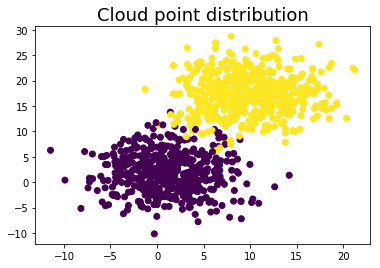

In [10]:
plt.scatter(logistic_x[:,0], logistic_x[:,1], c=logistic_y)
plt.title('Cloud point distribution', fontsize=18)

One of the most important thing that you need to know is that it really dosen't matter, which model you want to train and what data you will use for it.The interface always be the same. And now we are going to see it.

First of all, we, as in the previues time, create dataset and split it. Only in the preloaded data and the size of dataset are difference. 

In [11]:
logistic_dset = Dataset(np.arange(size), batch_class=MyBatch)
logistic_dset.cv_split()

As you can see, structure of pipeline was the same, name of methods, that contains model and name of this model, changes only.

In [12]:
inputs_config = {'input': {'shape': (2)},
                 'labels': {'shape': (1),
                            'name': 'targets'}}

In [13]:
BATCH_SIZE=10
train_logistic = (logistic_dset.train.p
                .load((logistic_x, logistic_y))
                .init_variable('current_loss', init_on_each_run=list)
                .init_model('dynamic',
                            Regressions,
                            'logistic',
                            config={'inputs': inputs_config,
                                    'loss': 'sigmoid_cross_entropy',
                                    'optimizer': {'name':'Adam', 
                                                  'learning_rate':0.01},
                                    'input_block/inputs': 'input',
                                    'body/units': 1,
                                    'output': dict(ops=['proba', 'labels'])})
                .train_model('logistic',
                             fetches='loss',
                             feed_dict={'input': B('input_data'),
                                        'labels': B('labels')},
                            save_to=V('current_loss'), mode='a', use_lock=True)
                .run(BATCH_SIZE, shuffle=True, n_epochs=10))

INFO:tensorflow:logits.dtype=<dtype: 'float32'>.


INFO:tensorflow:logits.dtype=<dtype: 'float32'>.


INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.


INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.


INFO:tensorflow:losses.dtype=<dtype: 'float32'>.


INFO:tensorflow:losses.dtype=<dtype: 'float32'>.


In [14]:
BATCH_SIZE = 1
test_logistic = (logistic_dset.test.p
                .import_model('logistic', train_logistic)
                .load((logistic_x, logistic_y))
                .init_variable('probability', init_on_each_run=list)
                .predict_model('logistic', 
                             fetches='Regressions/sigmoid' ,
                             feed_dict={'input': B('input_data'),
                                        'labels': B('labels')},
                             save_to=V('probability'), mode='a')
                .run(BATCH_SIZE, shuffle=False, n_epochs=1))

In [15]:
prob = np.array(test_logistic.get_variable('probability')).reshape(-1)
predict = np.array([0 if i < 0.5 else 1 for i in prob])
target = np.array(logistic_y[logistic_dset.test.indices].reshape(-1), dtype=np.int32)

percentage = len(np.where(target == predict)[0]) / len(target)
print('Percentage of true values: {}%'.format(round(percentage, 2)))

Percentage of true values: 0.98%


# Poisson regression is being used if the answer is count. 
Example shows how we can train poisson regression by using generated data from poisson regression.

In [16]:
size = 1000
NUM_DIM = 13
poisson_x, poisson_y = generate_poisson_data(np.random.random(NUM_DIM), size)

Below you can see the same cell, as previously, but with different names in models.

In [17]:
poisson_dset = Dataset(np.arange(size), batch_class=MyBatch)
poisson_dset.cv_split()

We can create our own loss function and use it to train model.

In [18]:
def loss_poisson(target, predictions):
    return tf.reduce_mean(tf.nn.log_poisson_loss(target, predictions))

In [19]:
inputs_config = {'input': {'shape': (13)},
                 'labels': {'shape': (1),
                            'name': 'targets'}}

In [20]:
BATCH_SIZE=100
train_poisson = (poisson_dset.train.p
                .load((poisson_x, poisson_y))
                .init_variable('shape')
                .init_model('dynamic', 
                            Regressions, 
                            'poisson',
                            config={'inputs': inputs_config,
                                    'loss': loss_poisson,
                                    'optimizer': {'name': 'Adam', 
                                                  'learning_rate': 0.02},
                                    'input_block/inputs': 'input',
                                    'body/units': 1,
                                    'output': dict(ops=['labels'])})
                .train_model('poisson',
                             fetches='loss',
                             feed_dict={'input': B('input_data'),
                                        'labels': B('labels')})
                .run(BATCH_SIZE, shuffle=True, n_epochs=150))

In [21]:
test_poisson = ((poisson_dset.test.p
                .load((poisson_x, poisson_y))
                .import_model('poisson', train_poisson)
                .init_variable('all_predictions', init_on_each_run=list)
                .init_variable('answers', init_on_each_run=list)
                .predict_model('poisson', 
                               fetches=['Regressions/predicted_poisson_answer', 'labels'],
                               feed_dict={'input': B('input_data'),
                                          'labels': B('labels')},
                               save_to=[V('all_predictions'), V('answers')], mode='a'))
                .run(BATCH_SIZE, shuffle=True, n_epochs=1))

In [22]:
pred = np.array(test_poisson.get_variable('all_predictions')).reshape(-1)
target = np.array(test_poisson.get_variable('answers')).reshape(-1)


true_var = np.mean((target - np.mean(target))**2)
predict_var = np.mean((pred - np.mean(pred))**2)

percent = np.mean(np.abs(pred - target))/np.mean(target)*100
print('Percentage of errors: {}%'.format(round(percent, 3)), 'Variance ratio: %.3f' % (predict_var / true_var))

Percentage of errors: 16.693% Variance ratio: 0.736


As you can see, we use three different model to train regressions and prediction. And use one batch class for it. It is like that because we want to show you, no matter what you want to train and what data you want to use for it, dataset always be the same.